### <p style="text-align: center; margin: 0;"> Міністерство освіти і науки України </p>
### <p style="text-align: center; margin: 0;"> Національний технічний університет України </p>
### <p style="text-align: center; margin: 0;"> «Київський політехнічний інститут імені Ігоря Сікорського» </p>
### <p style="text-align: center; margin: 0;"> «Інститут прикладного системного аналізу» </p>
### <p style="text-align: center; margin: 0;"> Кафедра математичних методів системного аналізу </p>
<br>

## <p style="text-align: center; margin: 0;"> Звіт </p>
### <p style="text-align: center; margin: 0;"> про виконання лабораторної роботи №2 </p>
### <p style="text-align: center; margin: 0;"> з дисципліни </p>
### <p style="text-align: center; margin: 0;"> «Розпізнавання образів» </p>
<br>

### <p style="text-align: right; margin: 0;"> Виконали: студенти ІV курсу &emsp;&emsp;</p>
### <p style="text-align: right; margin: 0;"> групи  КА-76  &emsp;&emsp;</p>
### <p style="text-align: right; margin: 0;"> Панасюк Я.І. &emsp;&emsp;</p>
### <p style="text-align: right; margin: 0;"> та групи  КА-74  &emsp;&emsp;</p>
### <p style="text-align: right; margin: 0;"> Іванов С.І. &emsp;&emsp;</p>
### <p style="text-align: right; margin: 0;"> Перевірила: &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;</p>
### <p style="text-align: right; margin: 0;"> Дідковська М.В. &emsp;&emsp;</p>
<br>

### <p style="text-align: center; margin: 0;"> Київ – 2020 </p>
<br>
<br>

<br>

# Завдання

Для початку реалізувати енкодер та декодер (плеєр) для відеоряду на основі методів оцінки руху. Відповідно вхідним файлом буде відеозапис (наприклад трейлер до Тенет), одним з виходів буде файлик у вашому форматі що містить гіпотетично стиснений відеоряд з наприклад інформації щодо руху кожного третього кадру і два сусідні у повному розмірі (MPEG-7 алгоритми з що ми їх дотично згадували в попередніх лекціях будуть в нагоді). Другим виходом буде власне відтворення відео з вашого файлу. Після того як ви налаштували ваш енкодер і плеєр, йдете до друга по команді що в цей час налаштовував свої енкодер і плеєр на основі іншого алгоритму апроксимації руху і ви починаєте об'єднувати зусилля: користуючись вашими енкодерами ви генеруєте ваші апроксимовані зображення та обчислюєте їх різницю в порівнянні з дійсним зображеннями з оригінального відеоряду, збираючи при цьому візуальні різниці для кожного з методів. Окрім цього слід зібрати метрику швидкодії енкодерів і плеєрів, порівняти отримані результати і залляти їх аналогічним чином в гуглдок. Бонусні бали за опцію datamoshing і запис та відтворення аудіо, підтримку більш ніж одного формату відео, сприйняття стрімів з Youtube.

<br>

# Хід роботи

основне завдання + підтримка більш ніж одного формату відео + відео з фреймів-різниць

## Алгоритми апроксимації руху

### Farneback method opt.flow calculation

Encoder

In [1]:
import numpy as np
import cv2
import time

# Get our sample video
cap = cv2.VideoCapture('walking.avi')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('Farn_encode.avi',fourcc, 20.0, (frame_width,frame_height))

# we will aproximate only even frames, while odd frms won't be change
odd_frame = True

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

t_start = time.time()
while(cap.isOpened()):
    ret, frame2 = cap.read()
    if not ret: break
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Create an image representing our opt.flow
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)    
    frame_flow_rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    
    
    cv2.imshow('actual footage', frame2)
    cv2.imshow('pure optical flow',frame_flow_rgb)
    
    # write frame to output video.
    if(odd_frame):
        out.write(frame2)
        odd_frame = False
    else:
        out.write(frame_flow_rgb)
        odd_frame = True
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    # Aaaaand... go to the next frame!
    prvs = next

t_end = time.time()
# time metric
Farn_encode_time = t_end - t_start

cap.release()
out.release()
cv2.destroyAllWindows()

Decoder

In [2]:
import numpy as np
import cv2
import time

# Get our sample video
cap = cv2.VideoCapture('walking.avi')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('Farn_decode.avi',fourcc, 20.0, (frame_width,frame_height))

# we will aproximate only even frames, while odd frms won't be change
odd_frame = True

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

t_start = time.time()
while(cap.isOpened()):
    ret, frame2 = cap.read()
    if not ret: break
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 30, 3, 5, 1.2, 0)
    
    h, w = flow.shape[:2]
    flow = -flow # here we invert the flow in order to get the previous image
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]

    frame_warped = cv2.remap(frame2, flow, None, cv2.INTER_LINEAR)
    
    cv2.imshow('warped', frame_warped)
    
    if(odd_frame):
        out.write(frame2)
        odd_frame = False
    else:
        out.write(frame_warped)
        odd_frame = True
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Aaaaand... go to the next frame!
    prvs = next

t_end = time.time()
# time metric
Farn_decode_time = t_end - t_start
    
cap.release()
out.release()
cv2.destroyAllWindows()

<br>

### Dual TV L1 method opt.flow calculation

Encoder

In [3]:
import numpy as np
import cv2
import time

# Get our sample video
cap = cv2.VideoCapture('walking.avi')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('Dual_encode.avi',fourcc, 20.0, (frame_width,frame_height))

# we will aproximate only even frames, while odd frms won't be change
odd_frame = True

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

t_start = time.time()
while(cap.isOpened()):
    ret, frame2 = cap.read()
    if not ret: break
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    optical_flow = cv2.optflow.DualTVL1OpticalFlow_create()
    flow = optical_flow.calc(prvs, next, None)
    
    # Create an image representing our opt.flow
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)    
    frame_flow_rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('actual footage', frame2)
    cv2.imshow('pure optical flow',frame_flow_rgb)
    
    # write frame to output video.
    if(odd_frame):
        out.write(frame2)
        odd_frame = False
    else:
        out.write(frame_flow_rgb)
        odd_frame = True
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    # Aaaaand... go to the next frame!
    prvs = next
    
t_end = time.time()
# time metric
Dual_encode_time = t_end - t_start

cap.release()
out.release()
cv2.destroyAllWindows()

Decoder

In [4]:
import numpy as np
import cv2
import time

# Get our sample video
cap = cv2.VideoCapture('walking.avi')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('Dual_decode.avi',fourcc, 20.0, (frame_width,frame_height))
odd_frame = True

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

t_start = time.time()
while(cap.isOpened()):
    ret, frame2 = cap.read()
    if not ret: break
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    optical_flow = cv2.optflow.DualTVL1OpticalFlow_create()
    flow = optical_flow.calc(prvs, next, None)
    
    h, w = flow.shape[:2]
    flow = -flow # here we invert the flow in order to get the previous image
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]

    frame_warped = cv2.remap(frame2, flow, None, cv2.INTER_LINEAR)
    
    cv2.imshow('warped', frame_warped)
    
    if(odd_frame):
        out.write(frame2)
        odd_frame = False
    else:
        out.write(frame_warped)
        odd_frame = True
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Aaaaand... go to the next frame!
    prvs = next

t_end = time.time()
# time metric
Dual_decode_time = t_end - t_start    
    
cap.release()
out.release()
cv2.destroyAllWindows()

<br>

## Порівняння алгоритмів

Точність

Створимо відео на якому зображено різницю між двома файлами. 

In [6]:
import cv2

def get_diff(v1,v2):
    # Get our sample video
    origin = cv2.VideoCapture(v1)
    aprox = cv2.VideoCapture(v2)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    frame_width = int(origin.get(3))
    frame_height = int(origin.get(4))
    out = cv2.VideoWriter(f'diff_({v1})_&&_({v2}).avi',fourcc, 20.0, (frame_width,frame_height))
    
    while(origin.isOpened() and aprox.isOpened()):
        ret1, frame1 = origin.read()
        ret2, frame2 = aprox.read() 
        if (ret1 == False or ret2 == False): break
        
        # compute difference
        difference = cv2.subtract(frame1, frame2)
         
        # color the mask red
        Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
        difference[mask != 255] = [0, 0, 255]
        out.write(difference)
            
    origin.release()
    aprox.release()
    out.release()
    cv2.destroyAllWindows()

In [7]:
get_diff('walking', 'Farn_decode')

In [8]:
get_diff('walking', 'Dual_decode')

In [9]:
get_diff('Dual_decode', 'Farn_decode')

Швидкість роботи

In [10]:
Farn_encode_time

225.7192506790161

In [11]:
Farn_decode_time

223.70712995529175

In [12]:
Dual_encode_time

2637.011543273926

In [13]:
Dual_decode_time

2381.591493368149

<br>

## Аналіз

З отриманих візуальних різниць та метрик швидкодії можемо зробити такі висновки:
- Farneback показав трохи менші візуальні різниці, в порівнянні з методом Dual TV-L1, хоча різниця для тестових відео виявилась несуттєвою;
- Dual TV-L1 був значно повільнішим в роботі, для деяких тестових відео метрики швидкодії цього методу в кілька разів перевищували відповідні метрики для методу Farneback.

Варто зазначити, що для значного поліпшення швидкодії цих методів можна подавати на вхід зображення (кадри) меншого розміру, наприклад зменшувати їх вдвічі по обох осях. В нашому прикладі це було наочно видно при подачі на вхід відео із меншою роздільною здатністю і, відповідно, розміром кадрів.

Обидва алгоритми, Dual TV-L1 та Farneback є алгоритмами для обчислення щільного (dense) optical flow. Методи апроксимації руху за допомогою Optical Flow демонструють значно кращу точність результатів апроксимації в порівнянні, наприклад, з block matching методами [1]. Вони також демонструють більшу стійкість при роботі із зображеннями зі спотвореннями, так, optical flow методи здатні витримувати поворот об’єкта до 4⁰ та деформацію зсуву до 6 відсотків без втрат в точності апроксимації.

Dense optical flow алгоритми, зокрема, працюють із щільним оптичним потоком, тобто вираховують зсув не окремих, а усіх точок зображення, на відміну від sparce або вибіркового оптичного потоку. Вибірковий потік зазвичай вираховується швидше, за щільний, проте деякі методи маєть не таку й значну різницю в швидкодіх та деякі задачі потребують знаходження оптичного потоку для усіх точок зображення.
	
Обидва методи працюють з показником інтенсивності точки, тобто яскравості або кольору (для кольорових зображень). Метод Dual TV-L1 ґрунтується на модифікації функціоналу, описаного в методі Horn-Schunck для врахування можливих розривів або переривчастості в оптичному потоці шляхом зміни квадратичних коефіцієнтів [4], і може бути представлений як мінімізація функціоналу, що є сумою повної варіації (Total Variance) векторного поля u та норми

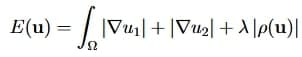

в той час як метод Farneback [3] ґрунтується на ідеї апроксимації зміни інтенсивності в околі точки за допомогою квадратичної форми

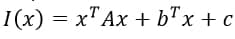

Варто відзначити, що обидва методи добре спрацьовують при невеликих зсувах і мають проблеми при зсувах, більших за 1 піксель. В такому випадку рекомендується використовувати multi-scaling: будувати «піраміду» з зображень із меншою роздільною здатністю, ніж оригінал. Алгоритм спочатку проходить по найнижчому рівню піраміди (із найменшою роздільною здатністю) і результат використовується як початкові точки на наступних рівнях [4].

При роботі із зображеннями із спотвореннями метод Farneback демонструє гірші [4] показники середньої кутової похибки (Average Angle Error) та середньої похибки кінцевої точки (Average End-Point Error) на датасетах Middlebury [5][6] та Sintel.

### Використані джерела

[1]   Zhi Liu, Jianwen Luo "Performance comparison of optical flow and block matching methods in shearing and rotating models", Proc. SPIE 10139, Medical Imaging 2017: Ultrasonic Imaging and Tomography, 1013917 (13 March 2017); https://doi.org/10.1117/12.2253689

[2]   Josh Harguess, Chris Barngrover, and Amin Rahimi "An analysis of optical flow on real and simulated data with degradations", Proc. SPIE 10199, Geospatial Informatics, Fusion, and Motion Video Analytics VII, 1019905 (1 May 2017); https://doi.org/10.1117/12.2265850

[3]   G. Farneback, "Fast and accurate motion estimation using orientation tensors and parametric motion models," Proceedings 15th International Conference on Pattern Recognition. ICPR-2000, Barcelona, Spain, 2000, pp. 135-139 vol.1, doi: 10.1109/ICPR.2000.905291.

[4]   J. S. Perez, E. Meinhardt-Llopis, and G. Facciolo. “TV-L1optical flow estimation”, IPOL Journal, 3:137–150, 2013

[5] https://vision.middlebury.edu/flow/eval/results/results-a1.php

[6] https://vision.middlebury.edu/flow/eval/results/results-e1.php


<br>